In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2  # Optional: for visualization
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
checkpoint_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/training/checkpoints/train_0414/checkpoint_epoch_137_metric_0.8345.pth'  # Example checkpoint file from your checkpoints directory
# Assuming your model architecture is defined (using build_unet from segmentation_models_pytorch for example)
# and that you have already built the model as 'model'

import segmentation_models_pytorch as smp

# Build the model (for PyTorch; adjust input parameters if needed)
model = smp.Unet(
    encoder_name="resnet34",   # backbone architecture
    encoder_weights="imagenet",  # pretrained on ImageNet for transfer learning
    in_channels=1,             # input channels (assume grayscale spectrogram)
    classes=1,                 # binary segmentation output
    activation="sigmoid"       # to get probability output
)
model.to(device)

# Load checkpoint if available
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model from checkpoint.")

/Users/remiliascarlet/Desktop/MDP/transfer_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded best model from checkpoint.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/prediction/csv/250403160001-Peach Mountain.csv'

df = pd.read_csv(file_path, on_bad_lines='skip')
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]
data_correct_shape = data.T[::-1]

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

In [4]:
import sys
sys.path.append('/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl')
from data_preprocessing.data_slicing import SpectrogramSlicer

tile_size = 256
stride = 256
slicer = SpectrogramSlicer(target_size=(256,256), overlap_ratio=0.20, random_offset=False)

start_time_str = '16:00:00'
end_time_str = '16:20:00'

if hasattr(data_correct_shape, 'values'):
    data_array = data_correct_shape.values
else:
    data_array = np.array(data_correct_shape)

tiles, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=data_array,
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# print(positions)
# print(tiles)

[(0, 0), (155, 0), (0, 204), (155, 204), (0, 408), (155, 408), (0, 612), (155, 612), (0, 816), (155, 816), (0, 1020), (155, 1020), (0, 1224), (155, 1224), (0, 1428), (155, 1428), (0, 1632), (155, 1632), (0, 1836), (155, 1836), (0, 2040), (155, 2040), (0, 2244), (155, 2244), (0, 2448), (155, 2448), (0, 2652), (155, 2652), (0, 2856), (155, 2856), (0, 3060), (155, 3060), (0, 3264), (155, 3264), (0, 3468), (155, 3468), (0, 3672), (155, 3672), (0, 3876), (155, 3876), (0, 4080), (155, 4080), (0, 4284), (155, 4284), (0, 4488), (155, 4488), (0, 4692), (155, 4692), (0, 4896), (155, 4896), (0, 5100), (155, 5100), (0, 5304), (155, 5304), (0, 5508), (155, 5508), (0, 5712), (155, 5712), (0, 5916), (155, 5916), (0, 6120), (155, 6120), (0, 6324), (155, 6324), (0, 6528), (155, 6528), (0, 6732), (155, 6732), (0, 6936), (155, 6936), (0, 7140), (155, 7140), (0, 7344), (155, 7344), (0, 7548), (155, 7548), (0, 7752), (155, 7752), (0, 7956), (155, 7956), (0, 8160), (155, 8160), (0, 8364), (155, 8364), (0, 8

In [5]:
from prediction_utils import normalize_tiles

tiles_array = normalize_tiles(tiles)

if tiles_array.ndim == 3:
    # (N, H, W) → (N, 1, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).unsqueeze(1)
elif tiles_array.ndim == 4:
    # (N, H, W, C) → (N, C, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).permute(0, 3, 1, 2)
else:
    raise ValueError(f"Unexpected tile array shape {tiles_array.shape}, "
                     "expected 3 or 4 dims.")

tiles_tensor = tiles_tensor.float().to(device)

model.eval()  # Set model to evaluation mode

# Run predictions
with torch.no_grad():
    preds = model(tiles_tensor)
    # Apply threshold of 0.5 to generate binary masks
    binary_preds = (preds > 0.5).float()

# Move predictions to CPU and convert to numpy
binary_preds_np = binary_preds.cpu().numpy()
print("Predicted masks shape:", binary_preds_np.shape)

原始tiles形状: (118, 256, 256)
归一化后tiles形状: (118, 256, 256)
Predicted masks shape: (118, 1, 256, 256)


In [12]:
from prediction.prediction_utils import reconstruct_mask
from data_preprocessing.data_label import apply_morphological_operations, apply_rolling_median_filter
reconstructed_mask = reconstruct_mask(binary_preds_np, positions, data_correct_shape.shape, tile_size)
print("Reconstructed mask shape:", reconstructed_mask.shape)

morph_mask = apply_morphological_operations(reconstructed_mask, erosion_radius=30, dilation_radius=35, operation_sequence=['erode', 'dilate'])
final_mask = apply_rolling_median_filter(morph_mask, window_size=5)

Reconstructed mask shape: (411, 11904)


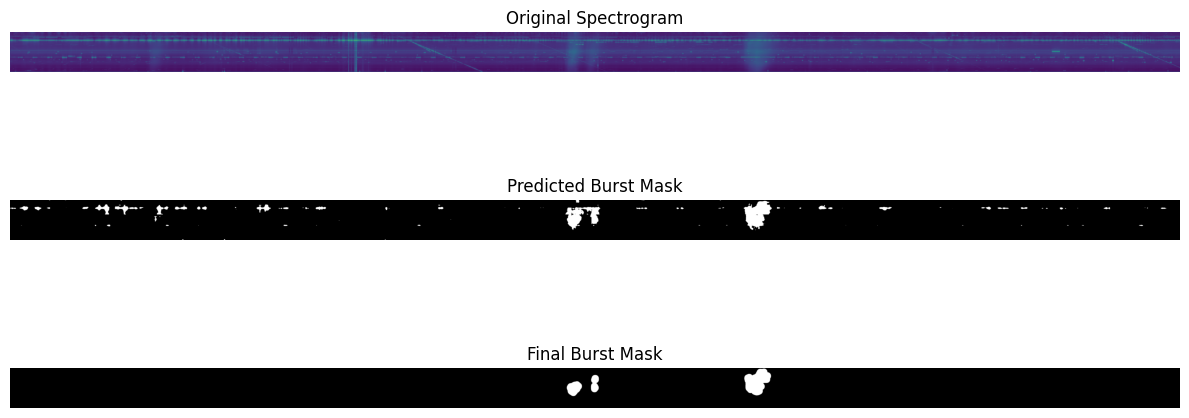

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.imshow(data_correct_shape, cmap='viridis')
plt.title("Original Spectrogram")
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(reconstructed_mask, cmap='gray')
plt.title("Predicted Burst Mask")
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(final_mask, cmap='gray')
plt.title("Final Burst Mask")
plt.axis('off')

plt.tight_layout()
plt.show()